[Jupyter Book](https://geo-smart.github.io/oceanography/intro.html) and [GitHub repo](https://github.com/geo-smart/oceanography).


# Data 2


needs to merge with Data.



In [1]:
# this cell connects to the RCA Zarr filesystem on the cloud and lists available data streams

import netCDF4
import xarray as xr
import s3fs

fs = s3fs.S3FileSystem(anon=True)

streamlist = fs.listdir('ooi-data', detail = False)

def InstrumentBreakout(s):
    print('Field breakout:', s[9:11], s[11:13], s[13:15], s[15:17], s[18:20], s[20:22], s[22:23], s[24:26], \
          s[27:32], s[32:33], s[33:36], s[46:])

print('List Oregon Slope Base Profiler streams:\n')
for s in streamlist:
    if 'SF01A' in s: print(s)
print()
print('Translation:')
print('  CTDPF / ctdpf                 CTD')
print('  PHSEN / phsen                 pH')
print('  FLORT / flort                 Fluorometer { FDOM, Chlor-A, Backscatter }')
print('  OPTAA / optaa                 Spectrophotometer') 
print('  PARAD / parad                 PAR')
print('  SPKIR / spkir                 Spectral Irradiance')
print('  NUTNR / nutnr_a_dark_sample   Nitrate: Dark sample (explain please)')
print('  NUTNR / nutnr_a_sample        Nitrate: ...')
print('  VELPT / velpt                 Velocity (current) ambiguous: on SCIP or affixed to platform?')
print('  PCO2W / pco2w                 pCO2')
print()

stream_choice = 15       # the 15th element in the file list corresponds to the Shallow Profiler, Oregon Slope Base site

print()
print('Full stream name:', streamlist[stream_choice])
print()
InstrumentBreakout(streamlist[stream_choice])
print()
print('The first field has CE for Coastal Endurance or RS for Regional Cabled Array.')
print('Fields 5, 6 and 7 give us shallow profiler site and choice of profiler or platform.')
print()
indenter = 4
print(' '*indenter + 'PC 01 B --> Oregon Offshore 200m Platform')
print(' '*indenter + 'SF 01 B --> Oregon Offshore Profiler')
print(' '*indenter + 'PC 01 A --> Oregon Slope Base Profiler')
print(' '*indenter + 'SF 01 A --> Oregon Slope Base Profiler')
print(' '*indenter + 'PC 03 A --> Axial Base 200m Platform')
print(' '*indenter + 'SF 03 A --> Axial Base Profiler')
print()
print('Non-shallow-profiler examples:')
print('  DP O3 A is the Axial Base Deep Profiler')
print('  LJ 01 A is the Oregon Slope Base Seafloor')
print()

List Oregon Slope Base Profiler streams:

ooi-data/RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample
ooi-data/RS01SBPS-SF01A-2D-PHSENA101-streamed-phsen_data_record
ooi-data/RS01SBPS-SF01A-3A-FLORTD101-streamed-flort_d_data_record
ooi-data/RS01SBPS-SF01A-3B-OPTAAD101-streamed-optaa_sample
ooi-data/RS01SBPS-SF01A-3C-PARADA101-streamed-parad_sa_sample
ooi-data/RS01SBPS-SF01A-3D-SPKIRA101-streamed-spkir_data_record
ooi-data/RS01SBPS-SF01A-4A-NUTNRA101-streamed-nutnr_a_dark_sample
ooi-data/RS01SBPS-SF01A-4A-NUTNRA101-streamed-nutnr_a_sample
ooi-data/RS01SBPS-SF01A-4B-VELPTD102-streamed-velpt_velocity_data
ooi-data/RS01SBPS-SF01A-4F-PCO2WA101-streamed-pco2w_a_sami_data_record

Translation:
  CTDPF / ctdpf                 CTD
  PHSEN / phsen                 pH
  FLORT / flort                 Fluorometer { FDOM, Chlor-A, Backscatter }
  OPTAA / optaa                 Spectrophotometer
  PARAD / parad                 PAR
  SPKIR / spkir                 Spectral Irradiance
  NUTNR / nutnr_

In [2]:
osb_profiler_streams = [sname for sname in streamlist if 'SF01A' in sname]
for s in osb_profiler_streams: 
    if 'ctdpf' in s: osb_sp_ctd = s

print('OSB CTD stream:', osb_sp_ctd)
print()

OSB CTD stream: ooi-data/RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample



In [3]:
def loadData(stream_name):
    fs = s3fs.S3FileSystem(anon=True)
    zarr_store = fs.get_mapper(stream_name)
    ds = xr.open_zarr(zarr_store, consolidated=True)
    return ds

siteData = loadData(osb_sp_ctd)
# siteData
print('site data is now lazy-loaded')

ValueError: unrecognized engine zarr must be one of: ['netcdf4', 'scipy', 'store']

In [ ]:
siteData.time[-1]

In [4]:
from shallowprofiler import *
from charts import *

profiles = ReadProfileMetadata()    # this is an error: Hardcoded for Jan 2022
how_many_charts = 3
profile_list = [n for n in range(how_many_charts)]   # quick check: use d['temperature'].z.plot()


Jupyter Notebook running Python 3


In [5]:
# This cell assembles a data dictionary "d" from the old-style datasets (that live within the repo)

d = {}

relative_path = 'rca/sensors/data/'
sitestring = 'osb'                    # available: osb = Oregon Slope Base
monthstring = 'jan22'                 # available: apr21, jul21, jan22

# error: apr21 and jul21 seem to fail on pCO2 despite data files present

def AssembleDataFilename(relative_path, site, instrument, time, sensor): 
    return relative_path + site + '_' + instrument + '_' + time + '_' + sensor + '.nc'

def GetSensorTuple(s, f):
    '''
    s is the sensor identifier string like 'temperature'
    f is the source filename like './../data/osb_ctd_jan22_temperature.nc' 
    '''
    df_sensor    = xr.open_dataset(f)[s]
    df_z         = xr.open_dataset(f)['z']
    range_lo     = ranges[s][0]
    range_hi     = ranges[s][1]
    sensor_color = colors[s]
    return (df_sensor, df_z, range_lo, range_hi, sensor_color)


for sensor in sensors:          # sensor is a list of 2 strings [sensor_str, instrument_str]
    f = AssembleDataFilename(relative_path, sitestring, sensor[1], monthstring, sensor[0])
    d[sensor[0]] = GetSensorTuple(sensor[0], f)

Attempting 3 charts



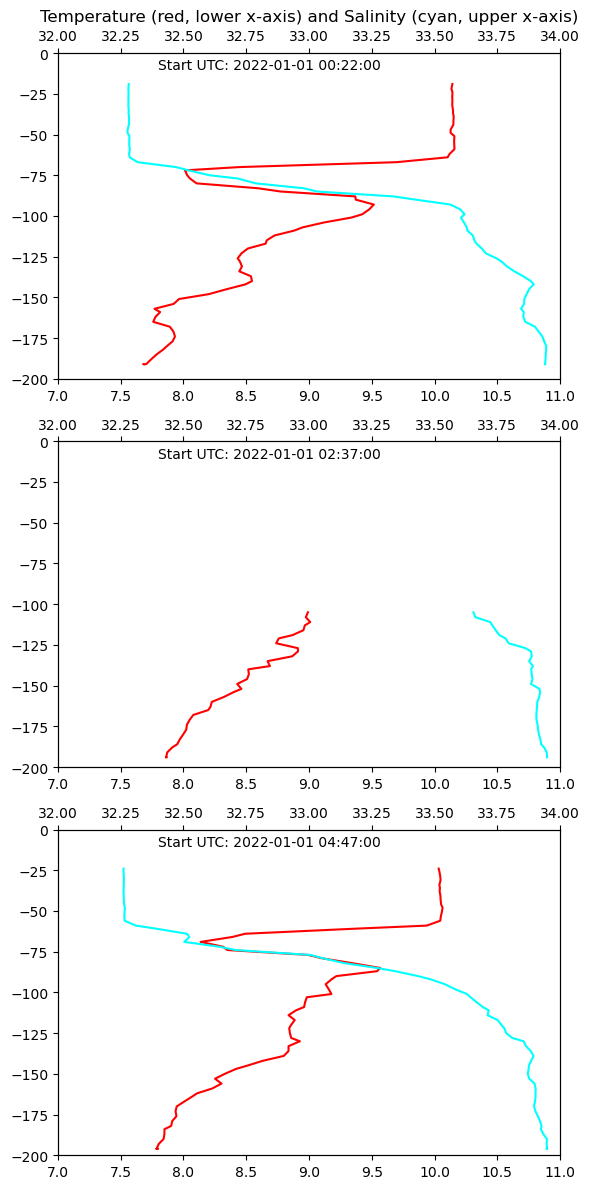

In [6]:
# temperature and salinity
fig,axs = ChartTwoSensors(profiles, [ranges['temperature'], ranges['salinity']], profile_list, 
                          d['temperature'][0], d['temperature'][1], 'Temperature', colors['temperature'],    'ascent',
                          d['salinity'][0],       d['salinity'][1],    'Salinity',  colors['salinity'], 'ascent', 6, 4)

In [ ]:
ChartSensor(profiles, [7., 11.], [0, 1, 2], ds.sea_water_temperature, -ds.sea_water_pressure, 'temperature', 'red', 'ascent', 8, 6)

In [ ]:
ChartSensor(profiles, [7., 11.], [0, 1, 2], ds.sea_water_temperature, -ds.sea_water_pressure, 'temperature', 'red', 'descent', 8, 6)

In [ ]:
# temperature: ascent versus descent
fig,axs = ChartTwoSensors(profiles, [ranges['temperature'], ranges['temperature']], [0, 1, 2], 
                          d['temperature'][0], d['temperature'][1], 'T-Ascent',   colors['temperature'],    'ascent',
                          d['temperature'][0], d['temperature'][1], 'T-Descent',  'green',                  'descent', 6, 4)

In [ ]:
t0, t1 = '2022-01-01T00', '2022-12-31T23'
ds = siteData.sel(time=slice(t0, t1))
ds.time[0], ds.time[-1]

In [ ]:
def SPDataReduce(ds, t0, t1, keepers, rename):
    """
    From a zarr Dataset for a shallow profiler stream ('ds') write a NetCDF file with just 
    time/sensor-value/depth over a time period typically no longer than a month.
      - check that the dimension and coordinate is 'time'
      - drop or rename data vars
      - drop attributes
    """
    
    if not len(ds.dims) == 1: 
        return False, "Dataset dims count is not 1 (as assumed)"
    if not list(dict(ds.dims))[0] == 'time': 
        return False, "Dataset dim is not 'time' (as assumed)"
    if not len(ds.coords) == 1: 
        return False, "Dataset coords count is not 1 (as assumed)"
    if not list(dict(ds.coords))[0] == 'time': 
        return False, "Dataset coord is not 'time' (as assumed)"
    
    ds = ds.sel(time=slice(t0, t1))
    
    for s in ds.data_vars:
        if not s in keepers: ds = ds.drop(s)                              # drop extraneous data vars
    for s in ds.data_vars: ds = ds.rename({s:rename[keepers.index(s)]})   # rename the others
    a = [s for s in ds.attrs]
    for p in a: ds.attrs.pop(p)
    return ds, 'looks ok'

t0, t1 = '2022-01-01T00', '2022-01-31T23'

ds_reduced, reply = SPDataReduce(ds, t0, t1, ['sea_water_temperature', 'sea_water_pressure'], 
                                 ['temperature', 'depth'], )
print(reply)
print(ds_reduced)

In [ ]:
ds_reduced.to_netcdf('osb_temp_jan_2022.nc') 

In [ ]:
# temperature: ascent versus descent
fig,axs = ChartTwoSensors(profiles, [ranges['temperature'], ranges['temperature']], [0, 1, 2], 
                          ds_reduced.temperature, -ds_reduced.depth,
                          'T-Ascent',   colors['temperature'],    'ascent',
                          ds_reduced.temperature, -ds_reduced.depth,
                          'T-Descent',  'green',                  'descent', 6, 4)

In [ ]:
# temperature: ascent versus descent
fig,axs = ChartTwoSensors(profiles, [ranges['temperature'], ranges['temperature']], [0, 1, 2], 
                          ds_reduced.temperature, -ds_reduced.depth,
                          'Zarr Data',   colors['temperature'],    'ascent',
                          d['temperature'][0], d['temperature'][1], 'OOI Data',   'blue',    'ascent', 6, 4)

```
df   = ds.to_dataframe()
    vals = [xr.DataArray(data=df[c], dims=['time'], coords={'time':df.index}, attrs=ds[c].attrs) for c in df.columns]
    ds   = xr.Dataset(dict(zip(df.columns, vals)), attrs=ds.attrs)
    ```

In [ ]:
ds_read = xr.open_dataset('./data/osb_temp_jan_2022.nc')


# temperature: ascent versus descent
fig,axs = ChartTwoSensors(profiles, [ranges['temperature'], ranges['temperature']], [0, 1, 2], 
                          ds_read.temperature, -ds_read.depth,
                          'Zarr Data',   colors['temperature'],    'ascent',
                          d['temperature'][0], d['temperature'][1], 'OOI Data',   'blue',    'ascent', 6, 4)